# analysis of altimetric data

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

import itide.tipe as tp

---

## setup cluster

In [2]:
from dask_jobqueue import PBSCluster
# for data preprocessing
#cluster = PBSCluster(processes=4, cores=4)
# for data postprocessing
cluster = PBSCluster()
w = cluster.scale(jobs=4)

In [3]:
from dask.distributed import Client
#client = Client() # with local cluster
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.0.131:55633 Dashboard: http://10.148.0.131:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
data_dir = '/home/c11-data/Test_aponte/alti/'

---

## load data

In [6]:
#ds = xr.open_zarr('/home2/pharos/othr/aponte/alti/tp')
ds = (xr.open_zarr(data_dir+'tp')
       .chunk({'time': int(1e5)})
      )

# rechunking seems to help with the following problems:
# distributed.core - INFO - Event loop was unresponsive in Worker for 19.96s.  
# This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
# ...
# distributed.worker - ERROR - Worker stream died during communication: tcp:
# tornado.util.TimeoutError: Timeout
#
# is this related to a slow file system?

#ds = ds.isel(time=slice(0,int(157384325/4)))

print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds

Dataset size = 8.8 GB


<xarray.Dataset>
Dimensions:         (time: 157384325)
Coordinates:
    latitude        (time) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
    longitude       (time) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1993-03-02T23:44:00.992296960 ... 2002-01-03T23:20:19.861993216
Data variables:
    cycle           (time) int16 dask.array<chunksize=(100000,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    track           (time) int16 dask.array<chunksize=(100000,), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2019-02-20T16:19:50Z
    date_issued:                     2019-02-20T16:19:50Z
    date_modified:                   2019-02-20T16:19:50Z
    geospatial_lat_max:              66.144524
    geospatial_lat_min:              -66.147525
    geospatial_lat_resolution:       0.012951000000001045
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.99963299999996
    geospatial_lon_min:              0.013045999999999999
    geospatial_lon_resolution:       0.034414499999996906
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2019-02-20T16:19:50Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        Topex/Poseidon
    processing_level:                L3
    product_version:                 2019
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                6.2_DUACS_DT2018_baseline
    source:                          Topex/Poseidon measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H5M7.505557S
    time_coverage_end:               1993-03-03T22:49:08Z
    time_coverage_resolution:        P1S
    time_coverage_start:             1993-03-02T23:44:00Z
    title:                           DT Topex/Poseidon Global Ocean Along tra...

In [7]:
print('start time: %s ' %str(ds.time[0].values))
print('end time:   %s ' %str(ds.time[-1].values))

start time: 1993-03-02T23:44:00.992296960 
end time:   2002-01-03T23:20:19.861993216 


---

<img src="altimetry_pic.png" width="400">

- SSH : Sea Surface Height
- MDT : Mean Dynamic Topography (temporal mean of the SSH above the Geoid over a period N)
- MSS : Mean Sea Surface (temporal mean of the SSH over a period N)
- SLA : Sea Level Anomaly deduced from the SSH using a MMS
- dac : Dynamic Atmospheric correction
- sla_filtered : Sea level anomaly
- sla_unfiltered : Sea level anomaly


---
## with [h3](https://github.com/uber/h3-py)

Python bindings for H3, a hierarchical hexagonal geospatial indexing system (see [here](https://uber.github.io/h3/))


Performance thread see [here](https://github.com/dask/dask/issues/4001)

In [8]:
ddf = ds.to_dask_dataframe().persist() # persist is necessary here

# will have to be deleted eventually (
ddf['longitude'] = (ddf['longitude']+180)%360 - 180
ddf = ddf[(ddf['longitude']<10)&(ddf['longitude']>-70)]
# )

In [9]:
# find hex cell
resolution = 5 # 5: 250 km^2; 6: 36 km^2
ddf['hex_id'] = (ddf.apply(tp.get_hex, axis=1, 
                           args=(resolution,), meta='string') # use 'category' instead?
                )
# Could add .astype('category') but it will lead to weird behaviors: 
# all categories are tracked throughout comptutations even if some categories are filtered out
# https://docs.dask.org/en/latest/dataframe-categoricals.html

In [10]:
#ddf = ddf.persist()

In [11]:
#ddf['latitude'].mean().compute()

In [12]:
ddf = ddf.set_index('hex_id').persist() # setting hex_id as index will facilitate grouping by hex_id
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track
hex_id,,,,,,,,,,,
85060903fffffff,1993-10-03 13:53:37.817217536,65.949056,-34.412824,38,-0.0333,0.009,-0.254,-1.1729,0.114,0.115,219
85060903fffffff,1993-10-03 13:53:38.895797504,65.956040,-34.277868,38,-0.0340,0.009,-0.255,-1.1681,0.100,0.085,219
85060903fffffff,1993-09-05 20:43:24.725473024,65.829500,-34.392710,36,-0.0772,0.018,-0.264,1.0042,0.011,0.022,18
85060903fffffff,1993-10-05 14:38:59.229449728,65.829500,-34.392710,39,-0.1875,-0.002,-0.264,-0.9083,0.055,0.060,18
85060903fffffff,1993-08-26 22:44:52.915655936,65.829500,-34.392710,35,-0.0095,0.005,-0.264,-0.2928,-0.008,-0.014,18


In [19]:
# store preprocessed data to parquet file
ddf.to_parquet(data_dir+'tipe.parquet', engine='fastparquet')

---

### load data from preprocessed file

In [6]:
# load parquet file
from dask.dataframe import read_parquet
ddf = read_parquet(data_dir+'tipe.parquet',
                   engine='fastparquet').persist()
# persist my not be necessary depending on operations that will follow

## get basic statistics

In [7]:
stats = (ddf.drop(columns=['time'])[['sla_unfiltered']]
            .groupby('hex_id')
            .aggregate(['count', 'mean', 'std'])
           ).compute()

stats = tp.add_lonlat(stats, reset_index=True)
stats.head()

print('stats number of rows = %d \n'%len(stats.index))
stats

stats number of rows = 53758 



hex_id sla_unfiltered                            lat  \
                                count      mean       std              
0      85060903fffffff            224  0.042991  0.079260  65.905912   
1      85060907fffffff            172  0.043395  0.072245  65.747368   
2      8506090bfffffff            381  0.046932  0.079917  65.994495   
3      8506090ffffffff            297  0.040798  0.082487  65.835769   
4      85060913fffffff            413  0.045622  0.074034  65.975229   
...                ...            ...       ...       ...        ...   
53753  85eeebc7fffffff            384  0.018003  0.038395 -65.965741   
53754  85eeebcbfffffff            535  0.017626  0.039780 -66.031557   
53755  85eeebcffffffff            324  0.016599  0.037108 -65.918904   
53756  85eeebd7fffffff            749  0.016842  0.039722 -66.125804   
53757  85eeebdbfffffff            288  0.016358  0.040375 -66.192117   

             lon  
                  
0     -34.371550  
1     -34.400027  
2     -34.675244  
3     -34.701967  
4     -34.039865  
...          ...  
53753 -37.678722  
53754 -36.988204  
53755 -37.286444  
53756 -37.776885  
53757 -37.081973  

[53758 rows x 6 columns]

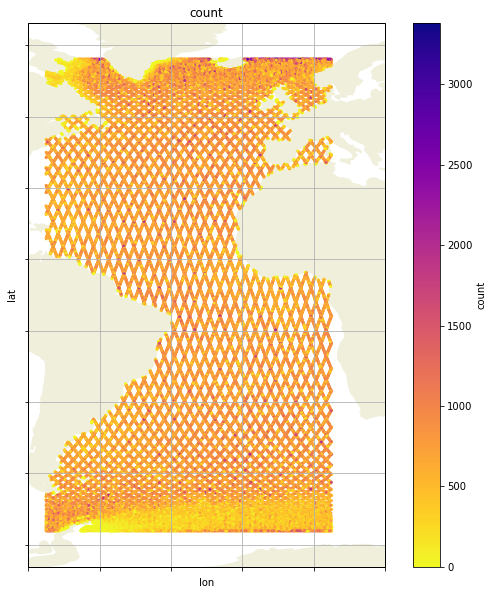

In [8]:
tp.plot_h3(stats, ['sla_unfiltered', 'count'])

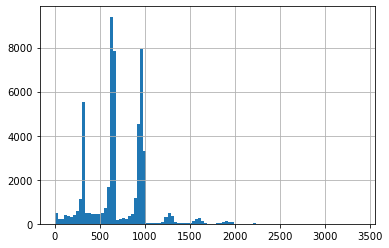

In [9]:
stats['sla_unfiltered']['count'].hist(bins=100)

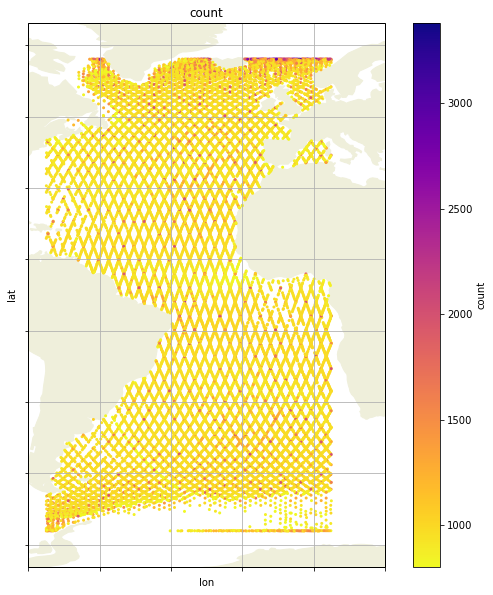

In [10]:
tp.plot_h3(stats[stats['sla_unfiltered']['count']>800], ['sla_unfiltered', 'count'])

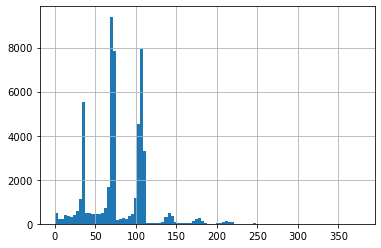

In [11]:
(stats['sla_unfiltered']['count']/9).hist(bins=100)

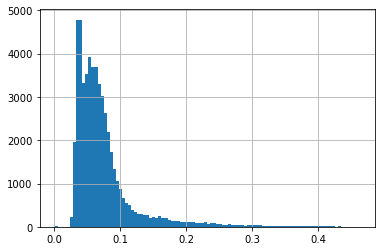

In [12]:
stats['sla_unfiltered']['std'].hist(bins=100)

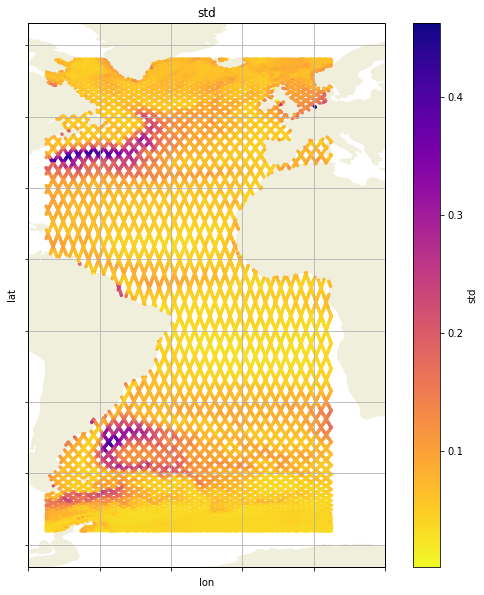

In [13]:
tp.plot_h3(stats, ['sla_unfiltered', 'std'])

## Tidal analysis

In [19]:
cst = ['M2','S2']

def add_lonlat_Aphi(df):
    """ Add amplitude and phase
    """
    df = tp.add_lonlat(df.reset_index().drop(columns=['level_1']))    
    for c in cst:
        df[c+'_A'] = np.abs(df[c])
        df[c+'_phi'] = np.angle(df[c])*180./np.pi
    return df

### on noise free sea level (ocean_tide)

In [15]:
har_1 = (ddf.groupby(['hex_id'])
          .apply(tp.harmonic_analysis, 
                 'ocean_tide', constituents=cst)
         ).compute()
har_1 = add_lonlat_Aphi(har_1)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


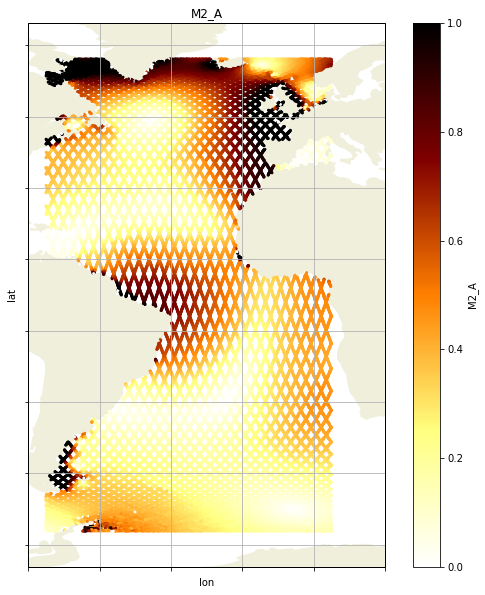

In [16]:
tp.plot_h3(har_1, 'M2_A', colormap='afmhot_r', vmax=1.)

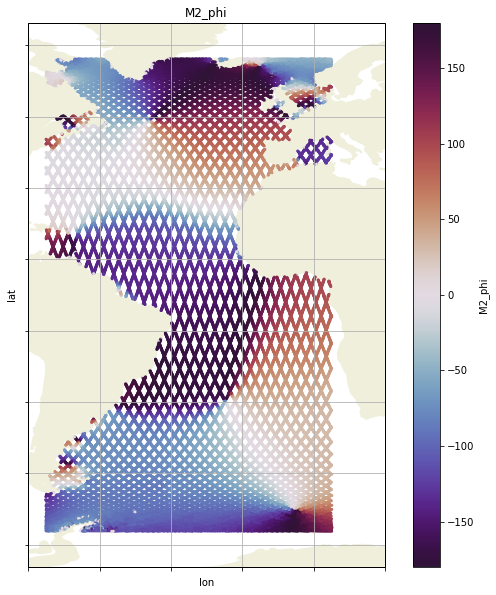

In [17]:
tp.plot_h3(har_1, 'M2_phi', colormap='twilight_shifted')

### on detided sea level (sla_unfiltered)

In [21]:
har_2 = (ddf.groupby(['hex_id'])
          .apply(tp.harmonic_analysis, 
                 'sla_unfiltered', constituents=cst)
         ).compute()
har_2 = add_lonlat_Aphi(har_2)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


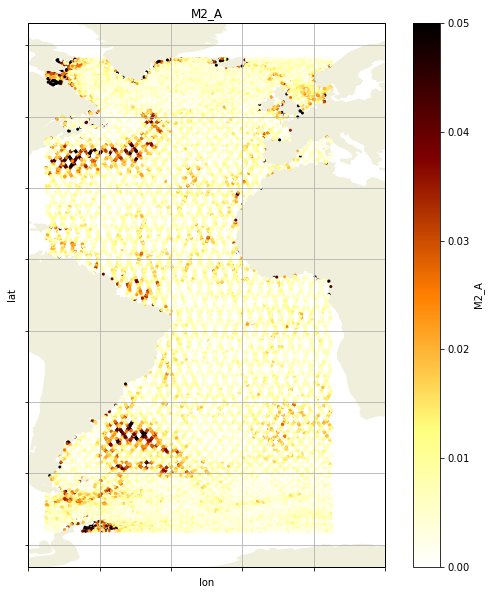

In [22]:
tp.plot_h3(har_2, 'M2_A', colormap='afmhot_r', vmax=.05)

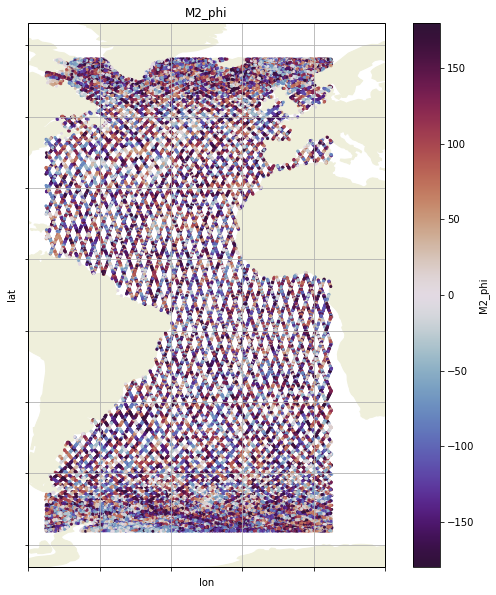

In [23]:
tp.plot_h3(har_2, 'M2_phi', colormap='twilight_shifted')

### on observed sea level (sla_unfiltered+ocean_tide)

In [24]:
ddf['sla_tide'] = ddf['sla_unfiltered'] + ddf['ocean_tide']

har_3 = (ddf.groupby(['hex_id'])
          .apply(tp.harmonic_analysis, 
                 'sla_tide', constituents=cst)
         ).compute()
har_3 = add_lonlat_Aphi(har_3)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """


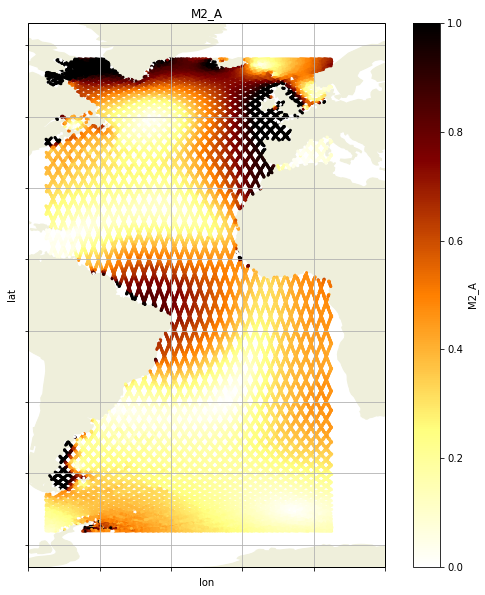

In [25]:
tp.plot_h3(har_3, 'M2_A', colormap='afmhot_r', vmax=1.)

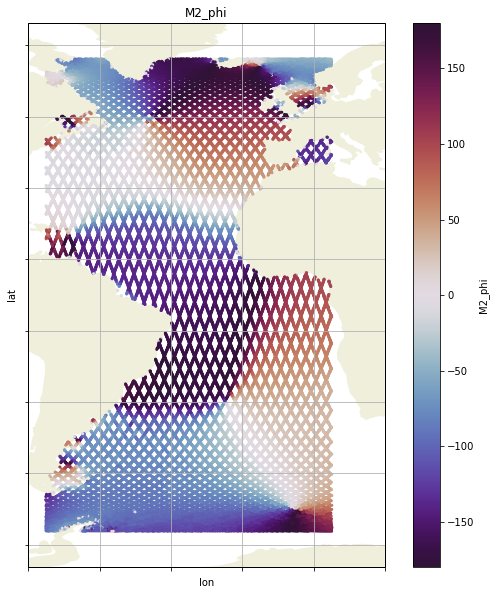

In [26]:
tp.plot_h3(har_3, 'M2_phi', colormap='twilight_shifted')

### compute noise prediction from number of points and noise

In [27]:
noise=stats['sla_unfiltered']['std']
N=stats['sla_unfiltered']['count']
stats['ecart_type']=1.5*noise/np.sqrt(N)
stats

hex_id sla_unfiltered                            lat  \
                                count      mean       std              
0      85060903fffffff            224  0.042991  0.079260  65.905912   
1      85060907fffffff            172  0.043395  0.072245  65.747368   
2      8506090bfffffff            381  0.046932  0.079917  65.994495   
3      8506090ffffffff            297  0.040798  0.082487  65.835769   
4      85060913fffffff            413  0.045622  0.074034  65.975229   
...                ...            ...       ...       ...        ...   
53753  85eeebc7fffffff            384  0.018003  0.038395 -65.965741   
53754  85eeebcbfffffff            535  0.017626  0.039780 -66.031557   
53755  85eeebcffffffff            324  0.016599  0.037108 -65.918904   
53756  85eeebd7fffffff            749  0.016842  0.039722 -66.125804   
53757  85eeebdbfffffff            288  0.016358  0.040375 -66.192117   

             lon ecart_type  
                             
0     -34.371550   0.007944  
1     -34.400027   0.008263  
2     -34.675244   0.006141  
3     -34.701967   0.007180  
4     -34.039865   0.005464  
...          ...        ...  
53753 -37.678722   0.002939  
53754 -36.988204   0.002580  
53755 -37.286444   0.003092  
53756 -37.776885   0.002177  
53757 -37.081973   0.003569  

[53758 rows x 7 columns]

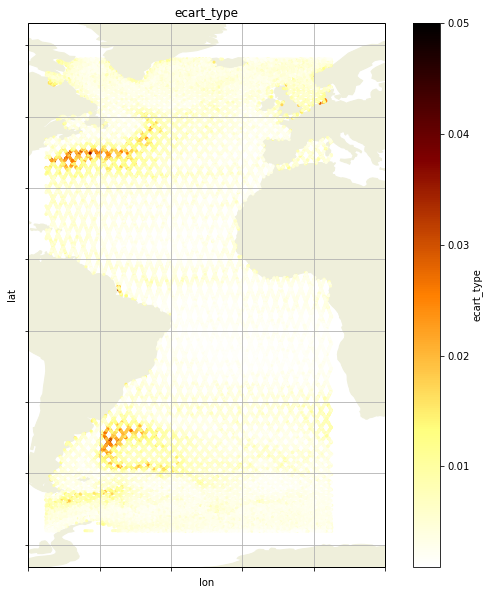

In [28]:
# look at places with a minimum of 100 points
tp.plot_h3(stats[stats['sla_unfiltered']['count']>100],
           'ecart_type', colormap='afmhot_r', vmax=.05)

### plot predicted vs oberved errors

In [30]:
df = har_2
df['ecart_type'] = stats['ecart_type']
df['count'] = stats['sla_unfiltered']['count']

In [31]:
count_min = 100
selection = df['count']>count_min

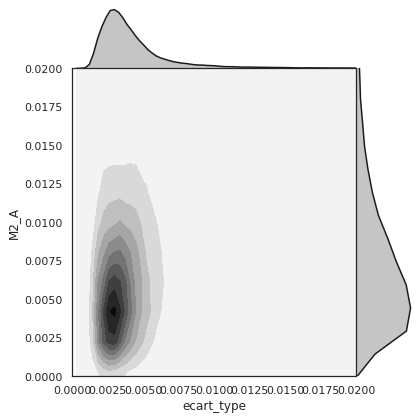

In [32]:
lims = (.01,.05)
g = (sns.jointplot("ecart_type", "M2_A",
                   data=df[selection], 
                   color="k",
                   xlim=lims, ylim=lims,
                   kind="kde", space=0)
    )
#        .plot_joint(sns.kdeplot, zorder=0, n_levels=6))

In [69]:
# bin by ecart_type and average
df['ecart_type_binned'] = pd.cut(df['ecart_type'], np.arange(0., 0.05,.01))

In [70]:
df_binned = (df[selection]['M2_A']
             .groupby(df['ecart_type_binned'][selection])
             .agg([np.sum, np.mean, np.std])
            )

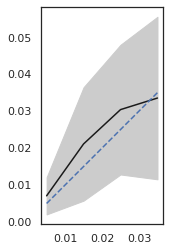

In [85]:
fig, ax = plt.subplots()
x = df_binned.index.map(lambda x: x.mid)
ax.fill_between(x, df_binned['mean']-df_binned['std'], 
                df_binned['mean']+df_binned['std'],
                color='0.8')
ax.plot(x, df_binned['mean'], color='k')
ax.plot(x, x, ls='--', color='b')
ax.set_aspect('equal', 'box')

---

In [86]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
